<a href="https://colab.research.google.com/github/KTada777/Bayesian_SolarCell_Opposed2D/blob/main/pymc5%2BNumpyro_S_shape_PVparameter_demo_TadaPSSA(Rs%3D0)_10k_10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cat /proc/cpuinfo | awk '/processor/,/cpu MHz/'

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.162
processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.162


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install 'pymc>=5.9'     #We need this for a while.  https://github.com/pymc-devs/pymc/issues/6964

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.4/472.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import numpy as np
#
import pymc as pm
import arviz as az
import time
#
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
#
import pymc.sampling_jax
import numpyro
#
print(pm.__version__)

5.10.3


In [ ]:
def pm_V2D_Roberts_g(Iph, Rp1, Rs, I01, n1, Rp2, I02, n2, I):
    Iph = Iph/1000     #mA
    I01 = I01 / 1e12   #pA
    I02 = I02 / 1e12   #pA
    n1Vt = n1 * 0.026  #Vt(RT)=26 mV
    n2Vt = n2 * 0.026  #Vt(RT)=26 mV

    X1 = np.log(I01 * Rp1 / n1Vt) + (I + Iph + I01) * Rp1 / n1Vt
    X2 = np.log(I02 * Rp2 / n2Vt) - (I - I02) * Rp2 / n2Vt

    return I * Rs + n1Vt * pm_Roberts_g(X1) - n2Vt * pm_Roberts_g(X2) - n1Vt * np.log(I01 * Rp1 / n1Vt) +  n2Vt * np.log(I02 * Rp2 / n2Vt)


In [ ]:
def pm_Roberts_g(x):
    e_1 = np.exp(-1)
    e1 = np.exp(1)
    g = pm.math.switch((x <= -(e_1)), x, pm.math.switch((x >= e1), np.log(x), -e1 + (1 + e1) / (2 * e1) * (x + e1)))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
#
# I-V of OPV from\n$Phys. Status \ Solidi \ A$ \n212 (2015) 1731.
#
X = np.array([0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
              0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
              0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3,
              0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4,
              0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5,
              0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6,
              0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7,
              0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8])
print(X)

Y = np.array([-5.72888889e-03, -5.69366667e-03, -5.65977778e-03, -5.62555556e-03, -5.57344444e-03,
              -5.53800000e-03, -5.49788889e-03, -5.45855556e-03, -5.41755556e-03, -5.36533333e-03,
              -5.31722222e-03, -5.27677778e-03, -5.23033333e-03, -5.18400000e-03, -5.13466667e-03,
               -5.07166667e-03, -5.02100000e-03, -4.97133333e-03, -4.91800000e-03, -4.86344444e-03,
               -4.79111111e-03, -4.73322222e-03, -4.67288889e-03, -4.61188889e-03, -4.54933333e-03,
               -4.46422222e-03, -4.39611111e-03, -4.32844444e-03, -4.25566667e-03, -4.18111111e-03,
               -4.10355556e-03, -4.00188889e-03, -3.92122222e-03, -3.83977778e-03, -3.75411111e-03,
               -3.66733333e-03, -3.54833333e-03, -3.45622222e-03, -3.36177778e-03, -3.26722222e-03,
               -3.16966667e-03, -3.03922222e-03, -2.93722222e-03, -2.83488889e-03, -2.73088889e-03,
               -2.62611111e-03, -2.48666667e-03, -2.38266667e-03, -2.27655556e-03, -2.17122222e-03,
               -2.06411111e-03, -1.96088889e-03, -1.82344444e-03, -1.72022222e-03, -1.61977778e-03,
               -1.51988889e-03, -1.42155556e-03, -1.29388889e-03, -1.20077778e-03, -1.11011111e-03,
               -1.02055556e-03, -9.35444444e-04, -8.23888889e-04, -7.44333333e-04, -6.67222222e-04,
               -5.93777778e-04, -5.20777778e-04, -4.51444444e-04, -3.63444444e-04, -3.01333333e-04,
               -2.39111111e-04, -1.80777778e-04, -1.24000000e-04, -5.03333333e-05,  3.22222222e-06,
               5.70000000e-05, 1.07888889e-04, 1.59555556e-04, 2.28000000e-04, 2.79666667e-04,3.33111111e-04])
print(Y)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 ]
[-5.72888889e-03 -5.69366667e-03 -5.65977778e-03 -5.62555556e-03
 -5.57344444e-03 -5.53800000e-03 -5.49788889e-03 -5.45855556e-03
 -5.41755556e-03 -5.36533333e-03 -5.31722222e-03 -5.27677778e-03
 -5.23033333e-03 -5.18400000e-03 -5.13466667e-03 -5.07166667e-03
 -5.02100000e-03 -4.97133333e-03 -4.91800000e-03 -4.86344444e-03
 -4.79111111e-03 -4.73322222e-03 -4.67288889e-03 -4.61188889e-03
 -4.54933333e-03 -4.46422222e-03 -4.39611111e-03 -4.32844444e-03
 -4.25566667e-03 -4.18111111e-03 -4.10355556e-03 -4.00188889e-03
 -3.92122222e-03 -3.83977778e-03 -3.75411111e-03 -3.66733333e-03
 -3

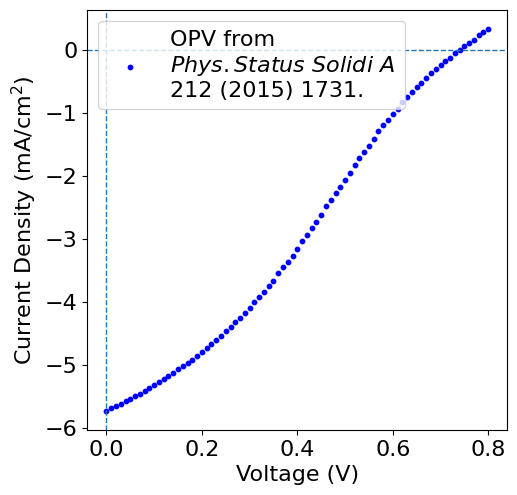

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current Density (mA/cm$^{2}$)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='OPV from\n$Phys. Status \ Solidi \ A$ \n212 (2015) 1731.'
           )
#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
plt.legend()

In [ ]:
#
t0 = time.perf_counter()
#
with pm.Model() as  model:

    Iph   = pm.Uniform('Iph', lower=1e-3, upper=1e2 )    #mA
    Rs    = 0
#    Rs    = pm.Uniform('Rs', lower=1e-1, upper=1e3 )    #Ohm
    Rp1   = pm.Uniform('Rp1', lower=1e1, upper=1e4)      #Ohm
    I01   = pm.Uniform('I01', lower=1e-4, upper=1e8 )    #pA
    n1    = pm.Uniform('n1', lower=0.5, upper=100 )      #Vt(RT)=26 mV
    Rp2   = pm.Uniform('Rp2', lower=1e1, upper=1e4)      #Ohm
    I02   = pm.Uniform('I02', lower=1e2, upper=1e10 )    #pA
    n2    = pm.Uniform('n2', lower=0.5, upper=100 )      #Vt(RT)=26 mV

    rmsd = pm.Uniform('rmsd', lower=0, upper=1e-2)
    mu = pm_V2D_Roberts_g(Iph, Rp1, Rs, I01, n1, Rp2, I02, n2, Y)

    x = pm.Normal('x', mu=mu,  sigma=rmsd, observed=X)

    trace_numpyro = pm.sampling_jax.sample_numpyro_nuts(10000, tune=10000, chains=2, target_accept=0.99)

t1 = time.perf_counter()
print( "elapsed time %.3f sec" % (t1-t0)  )

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

elapsed time 783.216 sec


In [ ]:
az.summary(trace_numpyro)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Iph,6.487000e+00,4.400000e-02,6.406000e+00,6.565000e+00,0.004,0.003,98.0,386.0,1.02
Rp1,4.107890e+02,3.337800e+01,3.539110e+02,4.775200e+02,3.125,2.220,118.0,439.0,1.02
I01,5.794656e+07,1.646201e+07,2.952726e+07,9.035350e+07,1688425.333,1197579.402,96.0,387.0,1.02
n1,6.424000e+00,3.870000e-01,5.763000e+00,7.180000e+00,0.040,0.029,94.0,385.0,1.02
Rp2,1.905720e+02,1.114400e+01,1.712340e+02,2.116670e+02,1.056,0.749,107.0,418.0,1.02
I02,1.216342e+08,2.494469e+07,8.047345e+07,1.699892e+08,2430068.708,1723096.948,100.0,384.0,1.03
n2,2.495000e+00,2.080000e-01,2.125000e+00,2.881000e+00,0.022,0.015,89.0,358.0,1.03
rmsd,1.000000e-03,0.000000e+00,1.000000e-03,1.000000e-03,0.000,0.000,935.0,1847.0,1.00


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


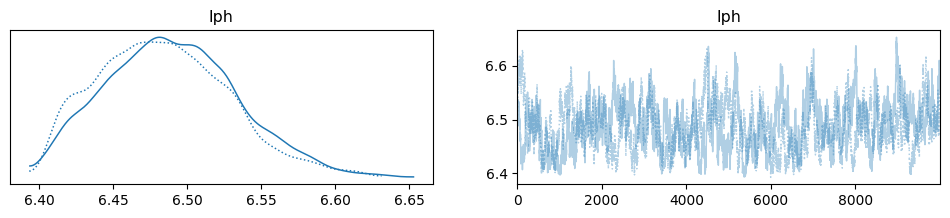

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Iph'))

In [ ]:
#with model:
#  az.plot_trace(trace_numpyro, var_names=('Rs'))

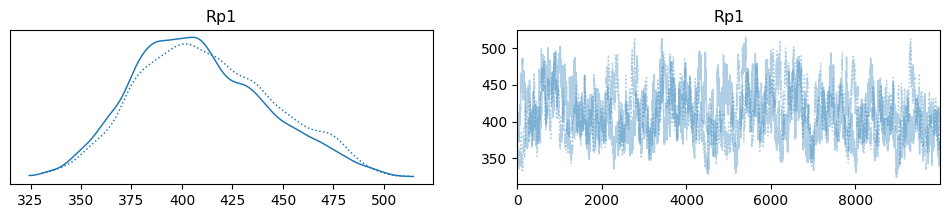

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rp1'))

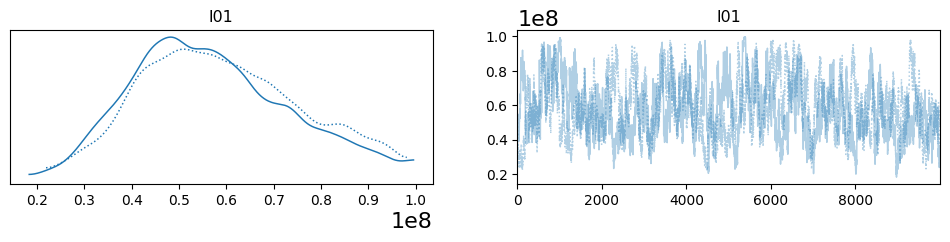

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('I01'))

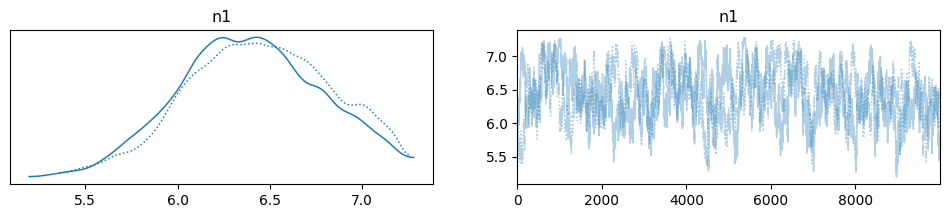

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('n1'))

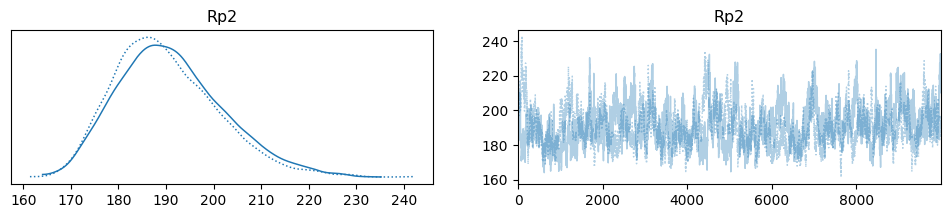

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rp2'))

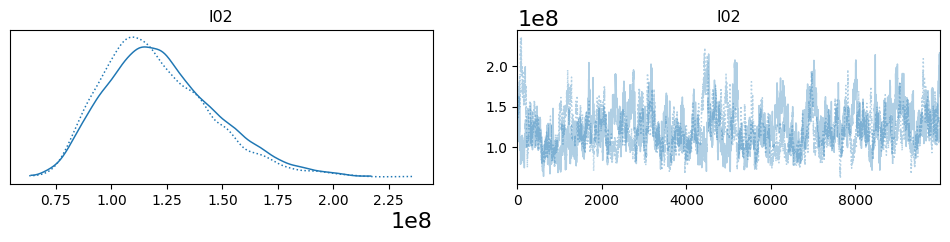

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('I02'))

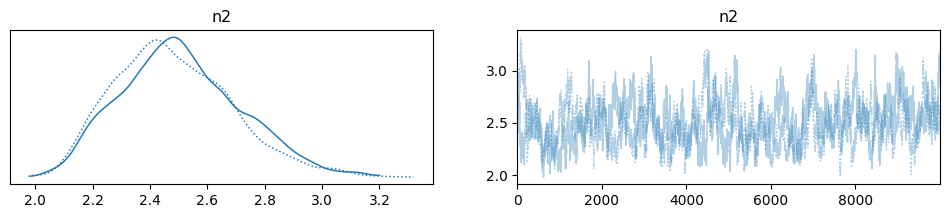

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('n2'))

In [ ]:
def Roberts_g(x):
    if x <= -(np.exp(-1)):
        g = x
    elif x >= (np.exp(1)):
        g = np.log(x)
    else:
        g = -np.exp(1) + (1 + np.exp(1)) / (2 * np.exp(1)) * (x + np.exp(1))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
def V2D_Roberts_g(Iph, Rp1, Rs, I01, n1, Rp2, I02, n2, I):
    Iph = Iph/1000     #mA
    I01 = I01 / 1e12   #pA
    I02 = I02 / 1e12   #pA
    n1Vt = n1 * 0.026
    n2Vt = n2 * 0.026

    X1 = np.log(I01 * Rp1 / n1Vt) + (I + Iph + I01) * Rp1 / n1Vt
    X2 = np.log(I02 * Rp2 / n2Vt) - (I - I02) * Rp2 / n2Vt
    return I * Rs + n1Vt * Roberts_g(X1) - n2Vt * Roberts_g(X2) - n1Vt * np.log(I01 * Rp1 / n1Vt) +  n2Vt * np.log(I02 * Rp2 / n2Vt)
print(V2D_Roberts_g(4.85e-2, 1e8, 0, 1.5e7, 2.4 , 4.6e4, 2.4e5, 9.5, 1e-5))

0.5499075292159682


In [ ]:
def calcV(Iph, Rp1, Rs, I01, n1, Rp2, I02, n2, I):
    I_list = I.tolist()
    V_list = [V2D_Roberts_g(Iph, Rp1, Rs, I01, n1, Rp2, I02, n2, item) for item in I_list]
    return np.array(V_list)

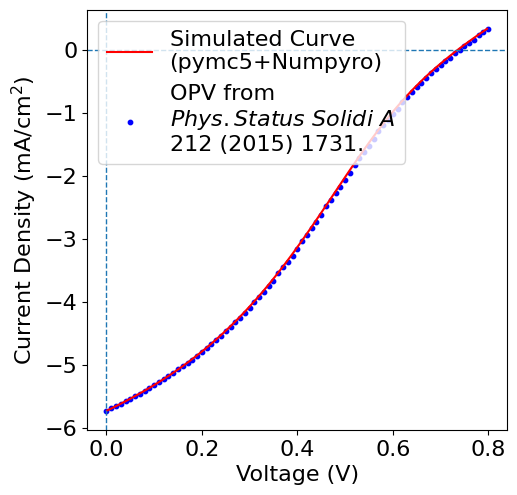

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current Density (mA/cm$^{2}$)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='OPV from\n$Phys. Status \ Solidi \ A$ \n212 (2015) 1731.'
           )

ymin = np.amin(Y)
ymax = np.amax(Y)
N = 100
Y_range = np.linspace(ymin, ymax, num=N, endpoint=True )

Q = az.summary(trace_numpyro)
Iph_m = Q.loc['Iph','mean']
Rs_m = 0
#Rs_m = Q.loc['Rs','mean']
Rp1_m = Q.loc['Rp1','mean']
I01_m = Q.loc['I01','mean']
n1_m = Q.loc['n1','mean']
Rp2_m = Q.loc['Rp2','mean']
I02_m = Q.loc['I02','mean']
n2_m = Q.loc['n2','mean']
V_list = calcV(Iph_m, Rp1_m, Rs_m, I01_m, n1_m, Rp2_m, I02_m, n2_m, Y_range)


ax1.plot(V_list, Y_range*1e3, color='red',
            label='Simulated Curve\n(pymc5+Numpyro)'
           )

#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])